In [22]:
import pandas as pd
import numpy as np
import yaml
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, GridSearchCV, KFold
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, f1_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.kernel_approximation import Nystroem
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn import metrics
from sklearn.metrics import f1_score

from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from imblearn.metrics import classification_report_imbalanced
from sklearn import neighbors

from joblib import dump, load
import pickle

In [23]:
file = open('../../../conf/global_conf.yml', 'r') 
conf = yaml.safe_load(file)
df = pd.read_csv(conf['local_data_path'] + "data_cleaned_final_sans_dummies.csv",index_col=0,low_memory=False)
print(df.shape)

(447136, 41)


In [3]:
# Recoder grav par ordre de gravié croissant
print(df.grav_rec.value_counts())

df['grav2'] = df['grav_rec'].replace(['Indemne', 'Blessé léger', 'Blessé hospitalisé', 'Tué'],
                        [1, 2, 3, 4]) 

df.grav2.dtype

grav_rec
Indemne               184548
Blessé léger          180388
Blessé hospitalisé     69999
Tué                    12201
Name: count, dtype: int64


C:\Users\dcons\AppData\Local\Temp\ipykernel_18676\2651863804.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['grav2'] = df['grav_rec'].replace(['Indemne', 'Blessé léger', 'Blessé hospitalisé', 'Tué'],


dtype('int64')

In [4]:
# drop des données inutiles (NB: on ne garde pas nb_usagers ici par cohérence avec les autres modèles)
data = df.drop(['grav', 'grav_rec', 'grav2', 'jour', 'date', 'dep', 'an'], axis=1) # 
y = df.grav2

In [5]:
print(data.columns)

Index(['mois', 'lum', 'agg', 'int', 'atm', 'col', 'lat', 'long', 'catr',
       'circ', 'prof', 'plan', 'surf', 'infra', 'situ', 'sexe', 'catv', 'obs',
       'obsm', 'manv', 'motor', 'weekend', 'heure', 'place_rec', 'age_usager',
       'eq_ceinture', 'eq_casque', 'eq_siege', 'eq_gilet', 'eq_airbag',
       'eq_gants', 'eq_indetermine', 'eq_autre', 'jour_chome', 'prox_pt_choc'],
      dtype='object')


In [6]:
numerical_features = ['age_usager', 'mois', 'heure', 'lat', 'long']
categorical_features = [col for col in data.columns if col not in numerical_features]
data[categorical_features] = data[categorical_features].astype('object')

In [7]:
# Quelles sont les categorical features non-binaires ?
nb_cat = data[categorical_features].apply(lambda x: x.nunique()) 
var_cat_mult = nb_cat[nb_cat > 2].index.tolist()
var_cat_mult

['lum',
 'col',
 'catr',
 'surf',
 'infra',
 'situ',
 'catv',
 'obsm',
 'manv',
 'motor',
 'place_rec']

# Scission en un ensemble d'apprentissage et un ensemble de test

In [8]:
data_train, data_test, y_train, y_test = train_test_split(data, y, test_size=0.2, random_state=42, stratify=y)

# Transformation des variables

Transformateur pour le passage en sin/cos des heures, et des mois

In [9]:
class TransfoHour(BaseEstimator, TransformerMixin):
    def __init__(self, column_name):
        self.column_name = column_name
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_transfo = X.copy()
        X_transfo[f'{self.column_name}_sin'] = np.sin(X_transfo[self.column_name]*(2.*np.pi/24))
        X_transfo[f'{self.column_name}_cos'] = np.cos(X_transfo[self.column_name]*(2.*np.pi/24))
        X_transfo = X_transfo.drop(self.column_name, axis=1)
        return X_transfo
    
    def get_feature_names_out(self):
        pass


class TransfoMonth(BaseEstimator, TransformerMixin):
    def __init__(self, column_name):
        self.column_name = column_name
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_transfo = X.copy()
        X_transfo[f'{self.column_name}_sin'] = np.sin((X_transfo[self.column_name]-1)*(2.*np.pi/12))
        X_transfo[f'{self.column_name}_cos'] = np.cos((X_transfo[self.column_name]-1)*(2.*np.pi/12))
        X_transfo = X_transfo.drop(self.column_name, axis=1)
        return X_transfo

    def get_feature_names_out(self):
        pass
    

## Création des transformers

In [10]:
var_cat_mult

['lum',
 'col',
 'catr',
 'surf',
 'infra',
 'situ',
 'catv',
 'obsm',
 'manv',
 'motor',
 'place_rec']

In [11]:
preprocessor = ColumnTransformer(transformers=[
    ("transfo_heure", TransfoHour('heure'), ['heure']),
    ("transfo_mois", TransfoMonth('mois'), ['mois']),
    ("transfo_lat_long", RobustScaler(), ['lat', 'long']),
    ('transfo_age_usager', StandardScaler(), ['age_usager']),
    ("one_hot_encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False),  var_cat_mult )],
    #['place_rec','catr', 'surf', 'infra', 'situ', 'motor', 'manv', 'obsm', 'catv', 'col', 'lum', 'nb_usagers_gr']
    remainder="passthrough"
).set_output(transform="pandas")

preprocessor_dropfirst = ColumnTransformer(transformers=[
    ("transfo_heure", TransfoHour('heure'), ['heure']),
    ("transfo_mois", TransfoMonth('mois'), ['mois']),
    ("transfo_lat_long", RobustScaler(), ['lat', 'long']),
    ('transfo_age_usager', StandardScaler(), ['age_usager']),
    ("one_hot_encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False, drop='first'), var_cat_mult )],
    remainder="passthrough"
).set_output(transform="pandas")

## Transformation sur la base de données
### train & test en gardant toutes les dummies

In [12]:
# Train : fit and transform
X_train_preprocessed = preprocessor.fit_transform(data_train)
X_train_preprocessed = X_train_preprocessed.infer_objects() # Convertir les types objects qui reste en integer
display(X_train_preprocessed.head())
print(X_train_preprocessed.shape)

# Test
X_test_preprocessed = preprocessor.transform(data_test)
X_test_preprocessed = X_test_preprocessed.infer_objects() # Convertir les types objects qui reste en integer
display(X_test_preprocessed.head())
print(X_test_preprocessed.shape)

,transfo_heure__heure_sin,transfo_heure__heure_cos,transfo_mois__mois_sin,transfo_mois__mois_cos,transfo_lat_long__lat,transfo_lat_long__long,transfo_age_usager__age_usager,one_hot_encoder__lum_0.0,one_hot_encoder__lum_1.0,one_hot_encoder__lum_2.0,...,remainder__eq_ceinture,remainder__eq_casque,remainder__eq_siege,remainder__eq_gilet,remainder__eq_airbag,remainder__eq_gants,remainder__eq_indetermine,remainder__eq_autre,remainder__jour_chome,remainder__prox_pt_choc
393104,2.588190e-01,0.965926,-8.660254e-01,5.000000e-01,0.127465,-0.339768,-0.125508,0.0,0.0,1.0,...,0,0,0,0,0,0,1,0,1,0
112384,2.588190e-01,-0.965926,-1.000000e+00,-1.836970e-16,0.268822,-0.018229,-0.125508,1.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0
73937,-8.660254e-01,-0.500000,8.660254e-01,-5.000000e-01,0.156440,-1.984122,2.637795,1.0,0.0,0.0,...,1,0,0,0,0,0,0,0,1,1
478649,1.224647e-16,-1.000000,-1.000000e+00,-1.836970e-16,-0.462057,0.702989,0.831020,1.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0
13179,-8.660254e-01,-0.500000,1.224647e-16,-1.000000e+00,0.243969,0.004446,0.087053,1.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0


(357708, 96)


,transfo_heure__heure_sin,transfo_heure__heure_cos,transfo_mois__mois_sin,transfo_mois__mois_cos,transfo_lat_long__lat,transfo_lat_long__long,transfo_age_usager__age_usager,one_hot_encoder__lum_0.0,one_hot_encoder__lum_1.0,one_hot_encoder__lum_2.0,...,remainder__eq_ceinture,remainder__eq_casque,remainder__eq_siege,remainder__eq_gilet,remainder__eq_airbag,remainder__eq_gants,remainder__eq_indetermine,remainder__eq_autre,remainder__jour_chome,remainder__prox_pt_choc
107018,0.965926,-2.588190e-01,0.866025,-5.000000e-01,0.069552,0.767177,0.405896,0.0,1.0,0.0,...,1,0,0,0,0,0,0,0,1,0
100707,-1.000000,-1.836970e-16,-0.866025,-5.000000e-01,-1.004329,0.810894,-0.816334,1.0,0.0,0.0,...,0,1,0,0,0,1,0,0,0,1
27593,-0.707107,-7.071068e-01,1.000000,6.123234e-17,0.249939,0.041768,-0.922615,1.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,1
483373,-1.000000,-1.836970e-16,-0.500000,-8.660254e-01,-0.978360,-0.045438,0.352756,1.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,1
344633,0.866025,-5.000000e-01,0.866025,5.000000e-01,0.449494,0.255488,0.140194,1.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0


(89428, 96)


In [15]:
data_train_fitted = preprocessor.fit_transform(data_train)

In [20]:
pickle.dump(preprocessor,open('../../../data/saved_models/' + 'preprocessor_knn.pkl','wb'))

In [21]:
scaler = pickle.load(open('../../../data/saved_models/' + 'preprocessor_knn.pkl','rb'))
X_test_verif = scaler.transform(data_test)
X_test_verif.head()

,transfo_heure__heure_sin,transfo_heure__heure_cos,transfo_mois__mois_sin,transfo_mois__mois_cos,transfo_lat_long__lat,transfo_lat_long__long,transfo_age_usager__age_usager,one_hot_encoder__lum_0.0,one_hot_encoder__lum_1.0,one_hot_encoder__lum_2.0,...,remainder__eq_ceinture,remainder__eq_casque,remainder__eq_siege,remainder__eq_gilet,remainder__eq_airbag,remainder__eq_gants,remainder__eq_indetermine,remainder__eq_autre,remainder__jour_chome,remainder__prox_pt_choc
107018,0.965926,-2.588190e-01,0.866025,-5.000000e-01,0.069552,0.767177,0.405896,0.0,1.0,0.0,...,1,0,0,0,0,0,0,0,1,0
100707,-1.000000,-1.836970e-16,-0.866025,-5.000000e-01,-1.004329,0.810894,-0.816334,1.0,0.0,0.0,...,0,1,0,0,0,1,0,0,0,1
27593,-0.707107,-7.071068e-01,1.000000,6.123234e-17,0.249939,0.041768,-0.922615,1.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,1
483373,-1.000000,-1.836970e-16,-0.500000,-8.660254e-01,-0.978360,-0.045438,0.352756,1.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,1
344633,0.866025,-5.000000e-01,0.866025,5.000000e-01,0.449494,0.255488,0.140194,1.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0


-16.93799131953963
0.7880469446577717
-0.8205307476833074
-52.04414115675584
47.780871127009526
0.06947049999134312


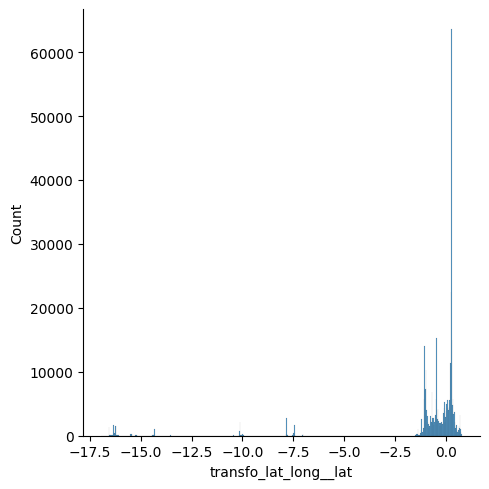

In [14]:
print(X_train_preprocessed.transfo_lat_long__lat.min())
print(X_train_preprocessed.transfo_lat_long__lat.max())
print(X_train_preprocessed.transfo_lat_long__lat.mean())

print(X_train_preprocessed.transfo_lat_long__long.min())
print(X_train_preprocessed.transfo_lat_long__long.max())
print(X_train_preprocessed.transfo_lat_long__long.mean())

sns.displot(X_train_preprocessed.transfo_lat_long__lat);

# KNN - tests

https://stats.stackexchange.com/questions/341/knn-and-unbalanced-classes

In [26]:
#Création du classifieur et construction du modèle sur les données d'entraînement
knn = neighbors.KNeighborsClassifier(n_neighbors=7, metric='minkowski', n_jobs=-1)
knn.fit(X_train_preprocessed, y_train)

KNeighborsClassifier(n_jobs=-1, n_neighbors=7)

In [27]:
y_pred = knn.predict(X_test_preprocessed)

In [49]:
print(knn.score(X_test_preprocessed, y_test))

0.6353491076620298


In [50]:
cr = classification_report(y_true=y_test, y_pred=y_pred)
print(cr)

              precision    recall  f1-score   support

           1       0.69      0.81      0.74     36910
           2       0.61      0.62      0.62     36078
           3       0.48      0.32      0.38     14000
           4       0.30      0.05      0.09      2440

    accuracy                           0.64     89428
   macro avg       0.52      0.45      0.46     89428
weighted avg       0.62      0.64      0.62     89428



In [51]:
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          1       0.69      0.81      0.74      0.74      0.78      0.61     36910
          2       0.61      0.62      0.74      0.62      0.68      0.45     36078
          3       0.48      0.32      0.94      0.38      0.54      0.28     14000
          4       0.30      0.05      1.00      0.09      0.23      0.05      2440

avg / total       0.62      0.64      0.78      0.62      0.68      0.48     89428



In [19]:
#Création du classifieur et construction du modèle sur les données d'entraînement
knn_dist = neighbors.KNeighborsClassifier(n_neighbors=7, metric='minkowski', n_jobs=-1, weights='distance')
knn_dist.fit(X_train_preprocessed, y_train)

KNeighborsClassifier(n_jobs=-1, n_neighbors=7, weights='distance')

In [20]:
y_pred_dist = knn_dist.predict(X_test_preprocessed)

In [21]:
cr = classification_report(y_true=y_test, y_pred=y_pred_dist)
print(cr)

              precision    recall  f1-score   support

           1       0.70      0.79      0.74     36910
           2       0.62      0.63      0.62     36078
           3       0.48      0.35      0.40     14000
           4       0.28      0.08      0.13      2440

    accuracy                           0.64     89428
   macro avg       0.52      0.46      0.47     89428
weighted avg       0.62      0.64      0.62     89428



In [22]:
print(classification_report_imbalanced(y_test, y_pred_dist))

                   pre       rec       spe        f1       geo       iba       sup

          1       0.70      0.79      0.76      0.74      0.78      0.60     36910
          2       0.62      0.63      0.74      0.62      0.68      0.46     36078
          3       0.48      0.35      0.93      0.40      0.57      0.31     14000
          4       0.28      0.08      0.99      0.13      0.28      0.07      2440

avg / total       0.62      0.64      0.78      0.62      0.69      0.48     89428



## KNN : Rééquilibrer les classes par undersampling

In [13]:
# Pour mieux prédire les tués, il faut rééquilibrer les classes (pas fait automatiquement), et utiliser les variables de la base avec toutes les dummies
#Random Undersampling
rUs = RandomUnderSampler()
X_ru, y_ru = rUs.fit_resample(X_train_preprocessed, y_train)
print('Classes échantillon undersampled :', dict(pd.Series(y_ru).value_counts()))

Classes échantillon undersampled : {1: 9761, 2: 9761, 3: 9761, 4: 9761}


## Modèle de référence

In [156]:
#Création du classifieur et construction du modèle sur les données d'entraînement
#knn_dist = neighbors.KNeighborsClassifier(n_neighbors=7, metric='minkowski', n_jobs=-1, weights='distance')
#knn_dist.fit(X_ru, y_ru)

knn_ref = neighbors.KNeighborsClassifier(n_jobs=-1)
knn_ref.fit(X_ru, y_ru)

KNeighborsClassifier(n_jobs=-1)

In [157]:
# prédiction
y_pred_ref = knn_ref.predict(X_test_preprocessed)

In [158]:
print(classification_report_imbalanced(y_test, y_pred_ref))

                   pre       rec       spe        f1       geo       iba       sup

          1       0.69      0.73      0.77      0.71      0.75      0.56     36910
          2       0.61      0.43      0.81      0.51      0.59      0.34     36078
          3       0.34      0.37      0.87      0.35      0.56      0.30     14000
          4       0.12      0.46      0.91      0.19      0.64      0.39      2440

avg / total       0.59      0.55      0.80      0.56      0.65      0.43     89428



In [159]:
pd.crosstab(y_test, y_pred_ref, rownames=['Classe réelle'], colnames=['Classe prédite'], normalize=0).round(2)

Classe prédite,1,2,3,4
Classe réelle,,,,
1,0.73,0.16,0.06,0.05
2,0.29,0.43,0.19,0.08
3,0.12,0.27,0.37,0.25
4,0.09,0.16,0.30,0.46


In [160]:
pd.crosstab(y_test, y_pred_ref, rownames=['Classe réelle'], colnames=['Classe prédite'])

Classe prédite,1,2,3,4
Classe réelle,,,,
1,26983,5905,2318,1704
2,10361,15677,7031,3009
3,1626,3781,5131,3462
4,209,379,740,1112


## Optimisation avec GridSearchCV

In [161]:
#Grid search
from sklearn.model_selection import GridSearchCV

knn = neighbors.KNeighborsClassifier(n_jobs=-1, metric = 'minkowski')

#params =  {'n_neighbors':[i for i in range(5,35,2)], "p" : [i for i in range(1, 5)], 'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'] } 
params =  {'n_neighbors':[i for i in range(5,30,5)], 
           'weights' : ['uniform','distance'],
           "p" : [i for i in range(1, 2)]} 
crossval = StratifiedKFold(n_splits = 5)

grid_knn = GridSearchCV(knn, params, cv=crossval, scoring='f1_weighted', n_jobs=-1)
grid_knn.fit(X_ru, y_ru)

grid_knn.best_params_

{'n_neighbors': 25, 'p': 1, 'weights': 'distance'}

In [162]:
dump(grid_knn, conf['local_data_path'] + 'grid_knn.joblib')

['C:/Users/c.pelat/Lecteur_D/perso/formation/Datascientest/projet/data/PROJET_DS_Accidents/grid_knn.joblib']

In [163]:
params

{'n_neighbors': [5, 10, 15, 20, 25],
 'weights': ['uniform', 'distance'],
 'p': [1]}

## Afficher les performances des différente paramétrisation du modèle

In [166]:
print(pd.DataFrame.from_dict(grid_knn.cv_results_).loc[:,['params', 'mean_test_score']]) 

                                              params  mean_test_score
0   {'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}         0.494982
1  {'n_neighbors': 5, 'p': 1, 'weights': 'distance'}         0.502832
2  {'n_neighbors': 10, 'p': 1, 'weights': 'uniform'}         0.511296
3  {'n_neighbors': 10, 'p': 1, 'weights': 'distan...         0.518586
4  {'n_neighbors': 15, 'p': 1, 'weights': 'uniform'}         0.516485
5  {'n_neighbors': 15, 'p': 1, 'weights': 'distan...         0.523503
6  {'n_neighbors': 20, 'p': 1, 'weights': 'uniform'}         0.521149
7  {'n_neighbors': 20, 'p': 1, 'weights': 'distan...         0.526885
8  {'n_neighbors': 25, 'p': 1, 'weights': 'uniform'}         0.523219
9  {'n_neighbors': 25, 'p': 1, 'weights': 'distan...         0.528154


## Récupération du meilleur modèle KNN

In [15]:
grid_knn = load(conf['local_data_path'] + 'grid_knn.joblib')
grid_knn

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=KNeighborsClassifier(n_jobs=-1), n_jobs=-1,
             param_grid={'n_neighbors': [5, 10, 15, 20, 25], 'p': [1],
                         'weights': ['uniform', 'distance']},
             scoring='f1_weighted')

In [32]:
optimal_knn = grid_knn.best_estimator_

In [35]:
# sauver le meilleur modele
dump(optimal_knn, "../../../data/saved_models/KNN_best.joblib")

['../../../data/saved_models/KNN_best.joblib']

In [55]:
# récupérer le meilleur modele 
optimal_knn = load("../../../data/saved_models/KNN_best.joblib")

In [56]:
# prédictions
y_pred_best_est = optimal_knn.predict(X_test_preprocessed)

In [41]:
y_pred_best_est[0]

1

In [ ]:
y_test[0]

### Sauvegarde du y_pred

In [18]:
dump(y_pred_best_est, "../../../data/saved_models/KNN_best_ypred.joblib")

['../../../data/saved_models/KNN_best_ypred.joblib']

### Sauvegarde de la matrice de confusion

In [19]:
nom_modele = "knn"

In [20]:
cm = confusion_matrix(y_test, y_pred_best_est) 
cm

array([[28784,  4029,  1930,  2167],
       [10507, 15254,  6567,  3750],
       [ 1421,  3015,  5110,  4454],
       [  176,   226,   611,  1427]], dtype=int64)

In [36]:
import pickle
print((X_test_preprocessed.columns.to_list()))
liste_path = '../../../data/img/' + f'ordre_colonnes_knn'
with open(liste_path, "wb") as temp:
    pickle.dump(X_test_preprocessed.columns.to_list(), temp)

['transfo_heure__heure_sin', 'transfo_heure__heure_cos', 'transfo_mois__mois_sin', 'transfo_mois__mois_cos', 'transfo_lat_long__lat', 'transfo_lat_long__long', 'transfo_age_usager__age_usager', 'one_hot_encoder__lum_0.0', 'one_hot_encoder__lum_1.0', 'one_hot_encoder__lum_2.0', 'one_hot_encoder__lum_3.0', 'one_hot_encoder__col_1.0', 'one_hot_encoder__col_2.0', 'one_hot_encoder__col_3.0', 'one_hot_encoder__col_4.0', 'one_hot_encoder__col_5.0', 'one_hot_encoder__col_6.0', 'one_hot_encoder__col_7.0', 'one_hot_encoder__catr_1', 'one_hot_encoder__catr_2', 'one_hot_encoder__catr_3', 'one_hot_encoder__catr_4', 'one_hot_encoder__catr_5', 'one_hot_encoder__catr_6', 'one_hot_encoder__catr_7', 'one_hot_encoder__catr_9', 'one_hot_encoder__surf_1.0', 'one_hot_encoder__surf_2.0', 'one_hot_encoder__surf_3.0', 'one_hot_encoder__surf_4.0', 'one_hot_encoder__surf_5.0', 'one_hot_encoder__surf_6.0', 'one_hot_encoder__surf_7.0', 'one_hot_encoder__surf_8.0', 'one_hot_encoder__surf_9.0', 'one_hot_encoder__inf

In [42]:
with open(liste_path, "rb") as temp:
    items = pickle.load(temp)
#items

In [37]:
X_test_preprocessed.iloc[0,:]
liste_test = '../../../data/img/' + f'test_knn'
with open(liste_test, "wb") as temp:
    pickle.dump(X_test_preprocessed.iloc[0,:].values, temp)

In [40]:
with open(liste_test, "rb") as temp:
    items = pickle.load(temp)
#items

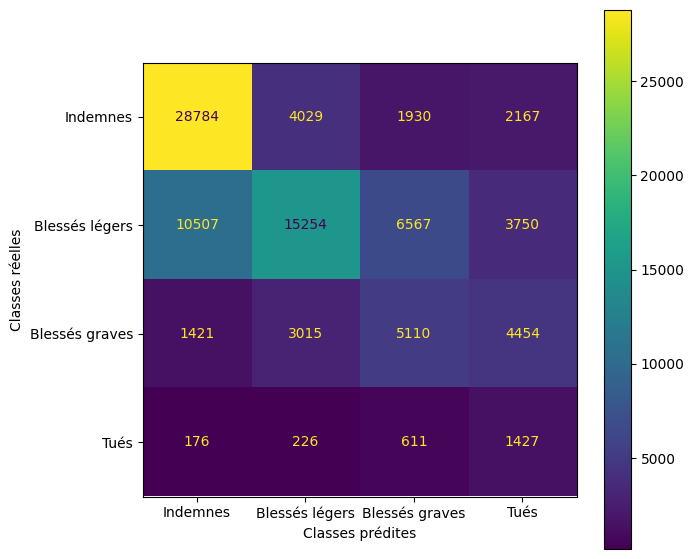

In [54]:
fig, ax = plt.subplots(figsize=(7,7))

ConfusionMatrixDisplay.from_predictions(
    y_true = y_test,
    y_pred = y_pred_best_est,
    display_labels=['Indemnes', 'Blessés légers', 'Blessés graves', 'Tués'],
    ax = ax
)
ax.set(xlabel='Classes prédites', ylabel='Classes réelles')
#ax.tick_params(left = False, bottom = False) 
 
plt.savefig('../../../data/img/' + f'{nom_modele}_confusion_matrix' + '.png', bbox_inches='tight')

### Sauvegarde du rapport de classification

In [42]:
cr= classification_report(y_test,
                           y_pred_best_est, 
                          target_names=['Indemnes', 'Blessés légers', 'Blessés graves', 'Tués'],
                          output_dict=True)
df_cr = pd.DataFrame(cr).transpose()
print(df_cr)
df_cr.to_csv('../../../data/img/' + f'{nom_modele}_report' + '.csv') 


                precision    recall  f1-score       support
Indemnes         0.703972  0.779843  0.739968  36910.000000
Blessés légers   0.677233  0.422806  0.520597  36078.000000
Blessés graves   0.359404  0.365000  0.362180  14000.000000
Tués             0.120953  0.584836  0.200450   2440.000000
accuracy         0.565539  0.565539  0.565539      0.565539
macro avg        0.465390  0.538121  0.455798  89428.000000
weighted avg     0.623335  0.565539  0.577603  89428.000000


In [33]:
print(classification_report_imbalanced(y_test, y_pred_gs))

                   pre       rec       spe        f1       geo       iba       sup

          1       0.70      0.78      0.77      0.74      0.77      0.60     36910
          2       0.68      0.42      0.86      0.52      0.60      0.35     36078
          3       0.36      0.36      0.88      0.36      0.57      0.30     14000
          4       0.12      0.58      0.88      0.20      0.72      0.50      2440

avg / total       0.62      0.57      0.83      0.58      0.67      0.45     89428



In [168]:
print(classification_report_imbalanced(y_test, y_pred_gs))

                   pre       rec       spe        f1       geo       iba       sup

          1       0.70      0.78      0.77      0.74      0.77      0.60     36910
          2       0.68      0.42      0.86      0.52      0.60      0.35     36078
          3       0.36      0.36      0.88      0.36      0.57      0.30     14000
          4       0.12      0.58      0.88      0.20      0.72      0.50      2440

avg / total       0.62      0.57      0.83      0.58      0.67      0.45     89428



In [66]:
# Pour comparaison : on remet le modele de reference
print(classification_report_imbalanced(y_test, y_pred_ref))

                   pre       rec       spe        f1       geo       iba       sup

          1       0.69      0.74      0.77      0.71      0.75      0.57     36910
          2       0.62      0.45      0.81      0.52      0.60      0.35     36078
          3       0.34      0.36      0.87      0.35      0.56      0.30     14000
          4       0.12      0.47      0.91      0.19      0.65      0.41      2440

avg / total       0.59      0.55      0.81      0.56      0.66      0.43     89428



In [169]:
pd.crosstab(y_test, y_pred_gs, rownames=['Classe réelle'], colnames=['Classe prédite'])

Classe prédite,1,2,3,4
Classe réelle,,,,
1,28784,4029,1930,2167
2,10507,15254,6567,3750
3,1421,3015,5110,4454
4,176,226,611,1427


In [170]:
pd.crosstab(y_test, y_pred_gs, rownames=['Classe réelle'], colnames=['Classe prédite'], normalize=0).round(2)

Classe prédite,1,2,3,4
Classe réelle,,,,
1,0.78,0.11,0.05,0.06
2,0.29,0.42,0.18,0.10
3,0.10,0.22,0.36,0.32
4,0.07,0.09,0.25,0.58


# Feature selection 
## On conserve uniquement les variables les plus importantes dans la meilleur  Random Forest

In [132]:
### Les 10 plus importantes features
import re
r_col = re.compile("one_hot_encoder__col")
r_place = re.compile("one_hot_encoder__place_rec")
r_obsm = re.compile("one_hot_encoder__obsm")
r_catv = re.compile("one_hot_encoder__catv")
r_catr = re.compile("one_hot_encoder__catr")
r_situ = re.compile("one_hot_encoder__situ")
r_heure = re.compile("heure")
r_prox_pt_choc = re.compile("prox_pt_choc")
r_mois = re.compile("mois")
r_lum = re.compile("one_hot_encoder__lum")
r_motor = re.compile("one_hot_encoder__motor")

selected_feats = ["remainder__eq_ceinture", 
            "transfo_age_usager__age_usager", 
             "remainder__agg", 
             "transfo_lat_long__lat",
             "remainder__obs", 
             "transfo_lat_long__long",
              "remainder__eq_casque",
              'remainder__circ',
              'remainder__sexe'
            ]

for mycol in X_ru.columns:
    if(len(r_col.findall(mycol))) > 0:
        selected_feats.append(mycol)

    if(len(r_place.findall(mycol))) > 0:
        selected_feats.append(mycol)

    if(len(r_obsm.findall(mycol))) > 0:
        selected_feats.append(mycol)

    if(len(r_catv.findall(mycol))) > 0:
        selected_feats.append(mycol)

    if(len(r_catr.findall(mycol))) > 0:
        selected_feats.append(mycol)
    
    if(len(r_situ.findall(mycol))) > 0:
        selected_feats.append(mycol)
    
    if(len(r_heure.findall(mycol))) > 0:
        selected_feats.append(mycol)

    if(len(r_lum.findall(mycol))) > 0:
        selected_feats.append(mycol)

    if(len(r_motor.findall(mycol))) > 0:
        selected_feats.append(mycol)

selected_feats

['remainder__eq_ceinture',
 'transfo_age_usager__age_usager',
 'remainder__agg',
 'transfo_lat_long__lat',
 'remainder__obs',
 'transfo_lat_long__long',
 'remainder__eq_casque',
 'remainder__circ',
 'remainder__sexe',
 'transfo_heure__heure_sin',
 'transfo_heure__heure_cos',
 'one_hot_encoder__lum_0.0',
 'one_hot_encoder__lum_1.0',
 'one_hot_encoder__lum_2.0',
 'one_hot_encoder__lum_3.0',
 'one_hot_encoder__col_1.0',
 'one_hot_encoder__col_2.0',
 'one_hot_encoder__col_3.0',
 'one_hot_encoder__col_4.0',
 'one_hot_encoder__col_5.0',
 'one_hot_encoder__col_6.0',
 'one_hot_encoder__col_7.0',
 'one_hot_encoder__catr_1',
 'one_hot_encoder__catr_2',
 'one_hot_encoder__catr_3',
 'one_hot_encoder__catr_4',
 'one_hot_encoder__catr_5',
 'one_hot_encoder__catr_6',
 'one_hot_encoder__catr_7',
 'one_hot_encoder__catr_9',
 'one_hot_encoder__situ_1.0',
 'one_hot_encoder__situ_2.0',
 'one_hot_encoder__situ_3.0',
 'one_hot_encoder__situ_4.0',
 'one_hot_encoder__situ_5.0',
 'one_hot_encoder__situ_6.0',
 

In [136]:
knn_20 = neighbors.KNeighborsClassifier(n_jobs=-1, n_neighbors=25, metric = 'minkowski', p = 1, weights = 'distance')
knn_20.fit(X_ru.loc[:, selected_feats], y_ru)

KNeighborsClassifier(n_jobs=-1, n_neighbors=25, p=1, weights='distance')

In [137]:
# prédiction
y_pred_20 = knn_20.predict(X_test_preprocessed.loc[:, selected_feats])

In [138]:
# performance
print(classification_report_imbalanced(y_test, y_pred_20))


                   pre       rec       spe        f1       geo       iba       sup

          1       0.71      0.76      0.79      0.74      0.77      0.60     36910
          2       0.67      0.45      0.85      0.54      0.62      0.36     36078
          3       0.36      0.36      0.88      0.36      0.56      0.30     14000
          4       0.12      0.59      0.88      0.20      0.72      0.51      2440

avg / total       0.62      0.57      0.83      0.58      0.68      0.45     89428



In [142]:
display(pd.crosstab(y_test, y_pred_20, rownames=['Classe réelle'], colnames=['Classe prédite']))

Classe prédite,1,2,3,4
Classe réelle,,,,
1,28116,4526,2062,2206
2,9770,16148,6292,3868
3,1307,3221,4993,4479
4,159,276,561,1444


In [143]:
display(pd.crosstab(y_test, y_pred_20, rownames=['Classe réelle'], colnames=['Classe prédite'], normalize=0).round(2))


Classe prédite,1,2,3,4
Classe réelle,,,,
1,0.76,0.12,0.06,0.06
2,0.27,0.45,0.17,0.11
3,0.09,0.23,0.36,0.32
4,0.07,0.11,0.23,0.59
